In [50]:
# imports
import os
# for the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout 
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

# for data manipulation and graphing
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

tf.random.set_seed(42) # set seed for reproducibility
tf.debugging.set_log_device_placement(False)

## Data preprocessing

In [51]:
# load the dataset
original_dataset = pd.read_csv('data-clickup.csv')

# just meanwhile
original_dataset.rename(columns={'Actual Hours' : 'Hours Logged'}, inplace=True)

# show the original data
original_dataset.head()


,Task ID,Assignee,TotalAssignee,Status,Time Estimate,Time Logged,Mes (drop down),Hours Estimate,Hours Logged
0,3cy8bv6,Andrea Rijana,1,COMPLETADO,16h 30m,16h 30m,3,16.5,16.5
1,3cy8c35,Andrea Rijana,1,COMPLETADO,14h,14h,3,14.0,14.0
2,3cy8c62,Andrea Rijana,1,COMPLETADO,4h 30m,4h 30m,4,4.5,4.5
3,3dv0hrf,Richard Pacheco,1,COMPLETADO,13h,13h,1,13.0,13.0
4,3dv0ht9,Richard Pacheco,1,COMPLETADO,6h,6h,1,6.0,6.0


In [52]:
# show the metadata
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Task ID          634 non-null    object 
 1   Assignee         631 non-null    object 
 2   TotalAssignee    634 non-null    int64  
 3   Status           634 non-null    object 
 4   Time Estimate    634 non-null    object 
 5   Time Logged      634 non-null    object 
 6   Mes (drop down)  634 non-null    int64  
 7   Hours Estimate   634 non-null    float64
 8   Hours Logged     634 non-null    float64
dtypes: float64(2), int64(2), object(5)
memory usage: 44.7+ KB


In [53]:
# drop all the unnecessary columns
clean_dataset = original_dataset.drop(columns=[
    'Task ID',
    'Assignee',
    'Status',
    'Time Estimate',
    'Time Logged',  
])

# check if is necessary to drop any row with NaN/empty/null values
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TotalAssignee    634 non-null    int64  
 1   Mes (drop down)  634 non-null    int64  
 2   Hours Estimate   634 non-null    float64
 3   Hours Logged     634 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 19.9 KB


### Data sampling

Split the data into train, test and validate samples to fit and evaluate the model

The percentage of each one will be

- 60% training
- 20% testing
- 20% validating

In [54]:
train_dataset, temp_test_dataset = train_test_split(clean_dataset, test_size=0.4)

validation_dataset, test_dataset = train_test_split(temp_test_dataset, test_size=0.5)

print("Samples shape")
print(f"    Train: {train_dataset.shape}")
print(f"    Test: {test_dataset.shape}")
print(f"    Validation: {validation_dataset.shape}")


Samples shape
    Train: (380, 4)
    Test: (127, 4)
    Validation: (127, 4)


### Data analysis

Calculate the correlation and other statistics on the train dataset

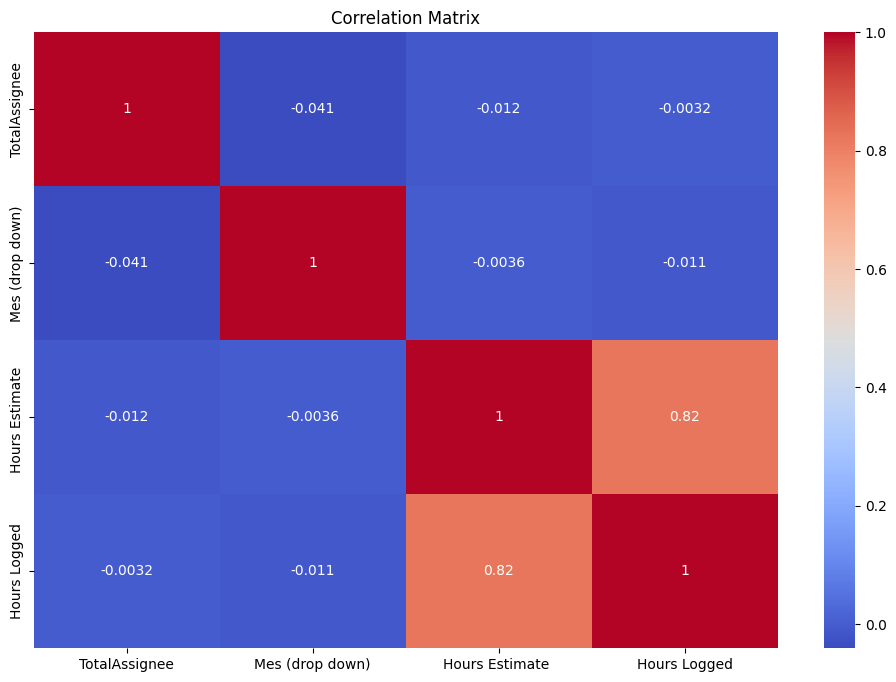

In [55]:
# correlation between the features and the target

correlation_matrix = clean_dataset.corr()
correlation_matrix['Hours Logged'].sort_values(ascending=False)

# plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

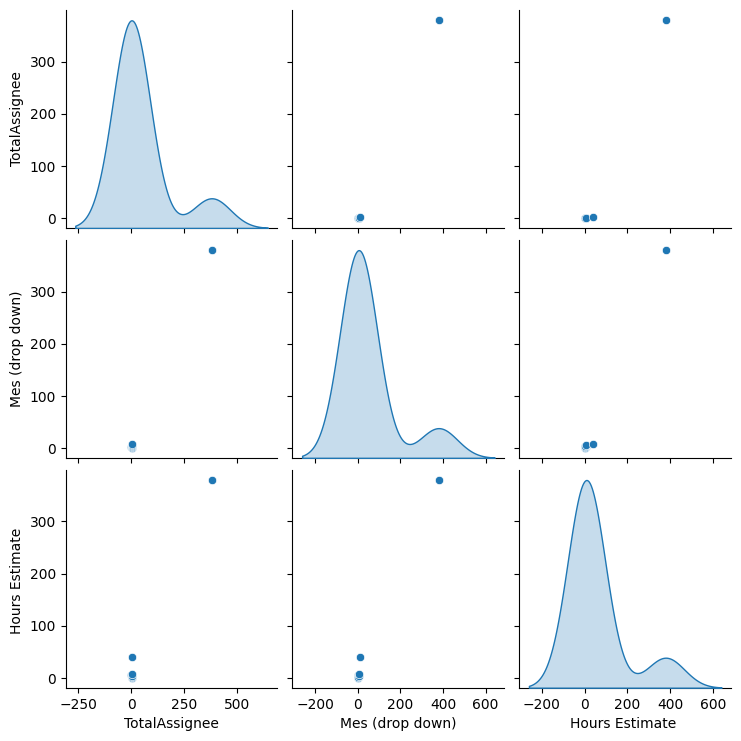

In [56]:
# correlation only between the features 
train_stats = train_dataset.describe()
train_stats.pop("Hours Logged")
sns.pairplot(train_stats[train_stats.columns], diag_kind="kde")

In [57]:
# another interesting statistics 
train_stats = train_dataset.describe()
train_stats.pop("Hours Logged")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
TotalAssignee,380.0,1.007895,0.088618,1.000000,1.0,1.0,1.000,2.0
Mes (drop down),380.0,4.373684,2.124699,1.000000,3.0,4.0,6.000,9.0
Hours Estimate,380.0,5.151974,5.964828,0.166667,1.0,3.0,7.125,40.0


### Feature prediction

The label "Hours Logged" is the actual goal for our model, we will remove it from every sample and keep it apart

In [58]:
train_label = train_dataset.pop('Hours Logged')
test_label = test_dataset.pop('Hours Logged')
validation_label = validation_dataset.pop('Hours Logged')

### Data normalization/Scaling

Subtract the mean of the training data and divide by the standard deviation of the training data.

In [59]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
normed_validation_data = norm(validation_dataset)

In [60]:
# show a part of the normalized data
normed_train_data.head()

,TotalAssignee,Mes (drop down),Hours Estimate
549,-0.089088,0.765434,1.148068
93,-0.089088,-1.117186,-0.612251
409,-0.089088,0.294779,0.058346
45,-0.089088,-1.117186,-0.193128
524,-0.089088,0.765434,1.818665


## Building the Neural Network Model

## Firts Model
Two hidden layers with 50 neurons each

In [62]:
def build_firts_model_two_hidden_layers():
    model = Sequential(name = "FirstModelTwoHiddenLayers")

    # Input layer
    model.add(Dense(10, input_shape = (normed_train_data.shape[1],)))

    # Hidden layer 
    model.add(Dense(50, Activation('relu')))
    model.add(Dense(50, Activation('relu')))

    # Output layer 
    model.add(Dense(1))

    learnig_rate = 0.001
    optimizer = optimizers.RMSprop(learning_rate=learnig_rate)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse']
    )

    return model

model = build_firts_model_two_hidden_layers()
print("Summary of the model")
model.summary()



Summary of the model
Model: "FirstModelTwoHiddenLayers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 10)                40        
                                                                 
 dense_9 (Dense)             (None, 50)                550       
                                                                 
 dense_10 (Dense)            (None, 50)                2550      
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 3191 (12.46 KB)
Trainable params: 3191 (12.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model training